In [1]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15232, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 15232 (delta 21), reused 33 (delta 20), pack-reused 15185
Receiving objects: 100% (15232/15232), 13.66 MiB | 16.77 MiB/s, done.
Resolving deltas: 100% (10331/10331), done.


In [3]:
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

/content/darknet


In [4]:
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old ==

In [5]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq" -O yolov4-csp.weights && rm -rf /tmp/cookies.txt

--2021-07-14 14:39:57--  https://docs.google.com/uc?export=download&confirm=4Ly4&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq
Resolving docs.google.com (docs.google.com)... 74.125.137.102, 74.125.137.138, 74.125.137.139, ...
Connecting to docs.google.com (docs.google.com)|74.125.137.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-20-docs.googleusercontent.com/docs/securesc/rlbr2s897b9pfa8f8ifk85foj1qiv12e/1soghn37rmno2357584qv18cr6k9s452/1626273525000/17800843676226924807/03053239860936830185Z/1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq?e=download [following]
--2021-07-14 14:39:57--  https://doc-00-20-docs.googleusercontent.com/docs/securesc/rlbr2s897b9pfa8f8ifk85foj1qiv12e/1soghn37rmno2357584qv18cr6k9s452/1626273525000/17800843676226924807/03053239860936830185Z/1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq?e=download
Resolving doc-00-20-docs.googleusercontent.com (doc-00-20-docs.googleusercontent.com)... 142.250.141.132, 2607:f8b0:4023:c0b::84
Connectin

In [6]:
from darknet import *
network, class_names, class_colors = load_network("cfg/yolov4-csp.cfg", "cfg/coco.data", "yolov4-csp.weights")
width = network_width(network)
height = network_height(network)
def darknet_helper(img, width, height):
  darknet_image = make_image(width, height, 3)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width
  height_ratio = img_height/height 

  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)
  return detections, width_ratio, height_ratio

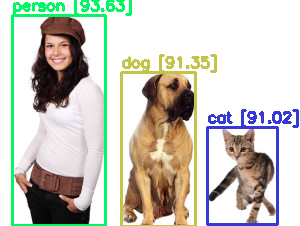

In [10]:
image = cv2.imread("/content/R.jpg")
detections, width_ratio, height_ratio = darknet_helper(image, width, height)

for label, confidence, bbox in detections:
 
  left, top, right, bottom = bbox2points(bbox)
  left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
  cv2.rectangle(image, (left, top), (right, bottom), class_colors[label], 2)
  cv2.putText(image, "{} [{:.2f}]".format(label, float(confidence)),
                    (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    class_colors[label], 2)
cv2_imshow(image)

Number of contours found =  87


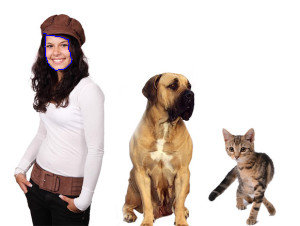

In [27]:
#detecting large object


image= cv2.imread('/content/R.jpg')
original_image= image

gray= cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

edges= cv2.Canny(gray, 50,200)

contours, hierarchy= cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
print ('Number of contours found = ', len(contours))


cv2.destroyAllWindows()


def get_contour_areas(contours):

    all_areas= []

    for cnt in contours:
        area= cv2.contourArea(cnt)
        all_areas.append(area)

    return all_areas


sorted_contours= sorted(contours, key=cv2.contourArea, reverse= True)


largest_item= sorted_contours[0]

cv2.drawContours(original_image, largest_item, -1, (255,0,0),1)
cv2.waitKey(0)
cv2_imshow(original_image)


cv2.waitKey(0)
cv2.destroyAllWindows()


Number of contours found =  87


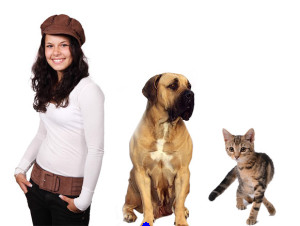

In [44]:
#detecting medium object
import cv2


image= cv2.imread('/content/R.jpg')
original_image= image

gray= cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

edges= cv2.Canny(gray, 50,200)


contours, hierarchy= cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
print ('Number of contours found = ', len(contours))


def get_contour_areas(contours):

    all_areas= []

    for cnt in contours:
        area= cv2.contourArea(cnt)
        all_areas.append(area)

    return all_areas

sorted_contours= sorted(contours, key=cv2.contourArea, reverse= (False))


smallest_item= sorted_contours[0]

cv2.drawContours(original_image, smallest_item, -1, (255,0,0),5)
cv2.waitKey(0)
cv2_imshow(original_image)


cv2.waitKey(0)
cv2.destroyAllWindows()


